In [1]:
cd D:\Saarbrucken\EDA_Research\vae-disentanglement\disentanglement_lib_pl

D:\Saarbrucken\EDA_Research\vae-disentanglement\disentanglement_lib_pl


In [2]:
# genernal
import torch
from torch import nn
import numpy as np
from architectures import encoders, decoders
from common.ops import Flatten3D, Unsqueeze3D, Reshape
from torch.nn import functional as F
import pickle
from common import dag_utils

# model loading
from gnncsvae_experiment import GNNCSVAEExperiment
from collections import defaultdict, namedtuple
import models
from common.notebook_utils import get_configured_dataset
from torch.utils.data import DataLoader
import os

# for plotting stuff
from matplotlib import cm as mpl_colormaps
from common.utils import CenteredNorm
import matplotlib.pyplot as plt 


# Multiscale + GNN structure test 

## Testing Prior GNN

In [24]:
#from common.special_modules import SimpleGNNLayer

# V, ifd, ofd =5, 2, 4

# #inp = torch.randn(size=(1, V, ifd))

# inp = torch.arange(10).type(torch.FloatTensor).view(1, V, ifd)
# print(inp)
# print("input shape: ", inp.shape)

# prior_gnn = SimpleGNNLayer(ifd, ofd, A.T, is_final_layer=True)
# print("Linear layer mat shape: ", prior_gnn.projection.weight.data.shape)
# prior_gnn.projection.weight.data = torch.Tensor(
#         [[1., 0.],
#         [0., 1.],
#         [1., 0.],
#         [0., 1.]]
# )
# prior_gnn.projection.bias.data = torch.zeros(ofd)
# print("input: ", inp)
# out = prior_gnn(inp)
# print(out)


# Load model and test prior components

In [3]:

ModelParams = namedtuple('ModelParams', ["z_dim", "l_dim", "num_labels" , "in_channels", 
                                        "image_size", "batch_size", "w_recon", "w_kld", "kl_warmup_epochs",
                                         "adjacency_matrix"])


algo_name = "GNNBasedConceptStructuredVAE"
checkpoint_path = r"D:\Saarbrucken\EDA_Research\vae-disentanglement\models\gnncsvae.ckpt"
z_dim = 5

model_params = ModelParams(
        [z_dim], 6, 0, 1, 64, 64, 1.0, 1.0, 0,
    r"D:\Saarbrucken\EDA_Research\vae-disentanglement\adjacency_matrices\dsprites_correlated.pkl"
)
exp_params = dict(
        in_channels=1,
        image_size=64,
        LR=1e-4,
        weight_decay=0.0,       
        dataset="dsprites_correlated",
        datapath=r"D:\Saarbrucken\EDA_Research\vae-disentanglement\datasets",
        droplast=True,        
        batch_size=64,
        num_workers=0,
        pin_memory=False,
        seed=123,
        evaluation_metrics=None,
        visdom_on=False,
        save_dir=None,
        max_epochs=1,
        l_zero_reg=False
)


# Model with 5-dim node feats

In [ ]:
vae_model_class = getattr(models, algo_name)
vae_model = vae_model_class(model_params)

vae_experiment = GNNCSVAEExperiment.load_from_checkpoint(
            checkpoint_path,
            vae_model=vae_model, 
            params=exp_params,
            dataset_params=dict(correlation_strength=0.2))

In [4]:

os.environ['DISENTANGLEMENT_LIB_DATA'] = r"D:\Saarbrucken\EDA_Research\vae-disentanglement\datasets"

dataset = get_configured_dataset("dsprites_correlated")
sample_loader = DataLoader(dataset, batch_size=64, shuffle = False, drop_last=True)

test_input, test_label = next(iter(sample_loader))
fwd_pass_results = vae_experiment.model.forward(test_input, current_device=test_input.device, labels = test_label)

Initialize [CorrelatedDSpritesDataset] with 737280 examples. Shape (737280, 64, 64).


In [5]:
fwd_pass_results.keys()

dict_keys(['x_recon', 'prior_mu', 'prior_logvar', 'posterior_mu', 'posterior_logvar', 'latents_predicted'])

In [7]:
fwd_pass_results['prior_mu'][1,:,:]

tensor([[ 0.2693,  0.0669,  0.7291, -0.0036,  1.4615],
        [ 0.2693,  0.0670,  0.7291, -0.0036,  1.4615],
        [ 0.2693,  0.0670,  0.7291, -0.0036,  1.4614],
        [ 0.2693,  0.0670,  0.7291, -0.0036,  1.4614],
        [ 0.2693,  0.0670,  0.7291, -0.0036,  1.4614]],
       grad_fn=<SliceBackward>)

## Check projection matrices

(10, 29)


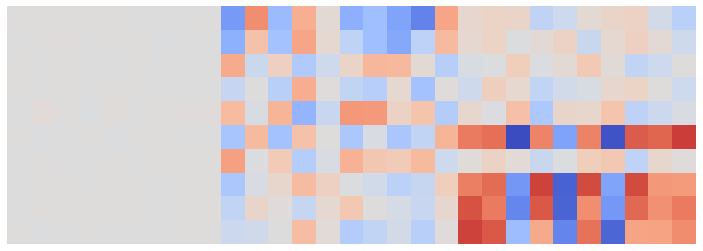

In [26]:
Ws = [vae_experiment.model.prior_gnn[i].projection.weight.detach() for i in range(3)]
Ws_to_plot = torch.cat(Ws, dim = 1).numpy()
print(Ws_to_plot.shape)
fig, axs = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=0)
axs.margins(0)
plt.axis('off')
plt.imshow(Ws_to_plot, cmap=mpl_colormaps.coolwarm, norm=CenteredNorm())

(10, 29)


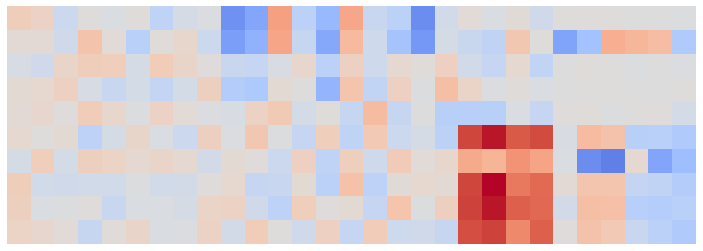

In [27]:
Ws = [vae_experiment.model.encoder_gnn[i].projection.weight.detach() for i in range(3)]
Ws_to_plot = torch.cat(Ws, dim = 1).numpy()
print(Ws_to_plot.shape)
fig, axs = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=0)
axs.margins(0)
plt.axis('off')
plt.imshow(Ws_to_plot, cmap=mpl_colormaps.coolwarm, norm=CenteredNorm())

In [28]:
 [vae_experiment.model.prior_gnn[i].projection.weight.size() for i in range(3)]

[torch.Size([10, 9]), torch.Size([10, 10]), torch.Size([10, 10])]

# For the 2D node feat dim model

In [4]:
algo_name = "GNNBasedConceptStructuredVAE"
checkpoint_path = r"D:\Saarbrucken\EDA_Research\vae-disentanglement\models\gnncsvae2d.ckpt"
z_dim = 2
model_params = ModelParams(
        [z_dim], 6, 0, 1, 64, 64, 1.0, 1.0, 0,
    r"D:\Saarbrucken\EDA_Research\vae-disentanglement\adjacency_matrices\dsprites_correlated.pkl"
)
vae_model_class = getattr(models, algo_name)
vae_model = vae_model_class(model_params)

vae_experiment = GNNCSVAEExperiment.load_from_checkpoint(
            checkpoint_path,
            vae_model=vae_model, 
            params=exp_params,
            dataset_params=dict(correlation_strength=0.2))

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
GNNBasedConceptStructuredVAE Model Initialized


(4, 17)
(4, 17)


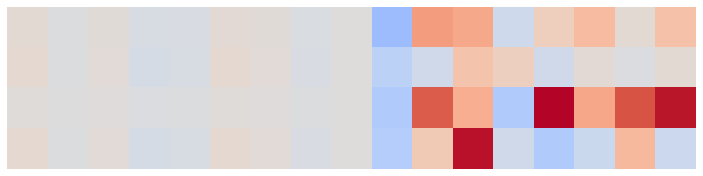

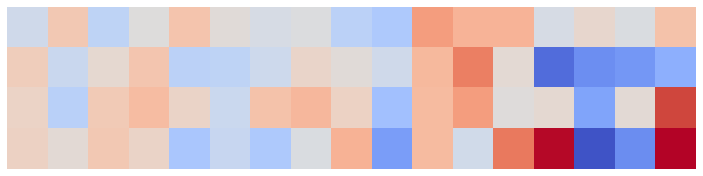

In [5]:
Ws = [vae_experiment.model.prior_gnn[i].projection.weight.detach() for i in range(3)]
Ws_to_plot = torch.cat(Ws, dim = 1).numpy()
print(Ws_to_plot.shape)
fig, axs = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=0)
axs.margins(0)
plt.axis('off')
plt.imshow(Ws_to_plot, cmap=mpl_colormaps.coolwarm, norm=CenteredNorm())

Ws = [vae_experiment.model.encoder_gnn[i].projection.weight.detach() for i in range(3)]
Ws_to_plot = torch.cat(Ws, dim = 1).numpy()
print(Ws_to_plot.shape)
fig, axs = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=0)
axs.margins(0)
plt.axis('off')
plt.imshow(Ws_to_plot, cmap=mpl_colormaps.coolwarm, norm=CenteredNorm())

# Red==positive, Blue==negative

In [8]:
vae_experiment.model.prior_gnn[0].projection.weight

Parameter containing:
tensor([[ 0.0663, -0.0145,  0.0393, -0.0600, -0.0453,  0.0603,  0.0362, -0.0366,
          0.0034],
        [ 0.0825, -0.0195,  0.0502, -0.0784, -0.0591,  0.0795,  0.0479, -0.0504,
          0.0041],
        [ 0.0316, -0.0059,  0.0186, -0.0286, -0.0209,  0.0289,  0.0167, -0.0171,
          0.0021],
        [ 0.0882, -0.0196,  0.0523, -0.0808, -0.0611,  0.0812,  0.0480, -0.0512,
          0.0043]], requires_grad=True)

In [9]:
vae_experiment.model.prior_gnn[1].projection.weight

Parameter containing:
tensor([[-0.5789,  0.6704,  0.5819, -0.1446],
        [-0.3088, -0.1422,  0.3604,  0.2173],
        [-0.4159,  1.0702,  0.5456, -0.4264],
        [-0.3753,  0.2776,  1.3673, -0.1371]], requires_grad=True)

In [7]:
vae_experiment.model.encoder_gnn[2].projection.weight

Parameter containing:
tensor([[-0.0908,  0.1481, -0.0526,  0.4951],
        [-1.6003, -1.2836, -1.1983, -0.9343],
        [ 0.1036, -1.0648,  0.0742,  1.5846],
        [ 1.8579, -1.8139, -1.3088,  1.8840]], requires_grad=True)

In [5]:
prior_gnn_out = None

with torch.no_grad():

    exogen_samples = torch.randn(size=(1, vae_experiment.model.num_nodes, vae_experiment.model.encoder_cnn.out_feature_dim))   
    prior_gnn_out = vae_experiment.model.prior_gnn(exogen_samples)

Input feats:  tensor([[[-7.9969e-01, -1.1550e+00,  9.6412e-01,  1.2225e+00, -9.8180e-01,
           4.7582e-01, -2.7427e-01,  2.0615e-03, -6.3219e-01],
         [-2.3088e-01,  1.0195e+00,  2.3654e-02, -3.3703e-01,  5.4476e-01,
          -2.2254e-01, -2.0557e+00, -4.2023e-01, -1.2114e+00],
         [ 7.9600e-03,  3.3948e+00,  7.6689e-01,  1.4326e-01, -5.8459e-01,
          -9.2519e-02, -4.6156e-01,  5.5915e-01,  1.2877e+00],
         [-4.2749e-01, -1.7315e-01,  6.3546e-01,  7.3383e-01, -2.1482e-01,
          -5.4844e-01, -3.4685e-01,  1.0338e+00,  1.1010e+00],
         [-1.7646e+00,  7.5123e-02, -1.6798e+00,  1.2652e-01, -1.2977e+00,
          -2.8057e-01,  1.4096e+00, -1.5187e+00,  2.5298e-01]]])
Projected feats:  tensor([[[ 0.3271, -1.0143, -0.7150,  0.3834],
         [ 0.2277, -1.1469, -0.7584,  0.2514],
         [ 0.2987, -1.0593, -0.7223,  0.3427],
         [ 0.2229, -1.1561, -0.7620,  0.2404],
         [ 0.2955, -1.0452, -0.7299,  0.3452]]])
Exchanged feats:  tensor([[[ 0.3271, -1

In [16]:
# already after the first projection, values are very similar
vae_experiment.model.prior_gnn[0](exogen_samples)

tensor([[[ 0.4093, -0.7022, -0.5794,  0.4828],
         [ 0.4093, -0.7076, -0.5766,  0.4833],
         [ 0.4480, -0.6749, -0.5656,  0.5306],
         [ 0.2955, -0.7814, -0.6187,  0.3378],
         [ 0.3965, -0.7163, -0.5839,  0.4648]],

        [[ 0.4339, -0.6893, -0.5708,  0.5119],
         [ 0.3732, -0.7306, -0.5929,  0.4403],
         [ 0.5568, -0.5555, -0.5158,  0.6565],
         [ 0.4293, -0.6876, -0.5723,  0.5080],
         [ 0.2707, -0.7933, -0.6268,  0.3073]]], grad_fn=<TanhBackward>)